<a href="https://colab.research.google.com/github/prissysin68/Coursera_Capstone/blob/main/Rental_in_Singapore_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries

#data analysis
import pandas as pd
import numpy as np

#web scraping and url requests 
import requests
from bs4 import BeautifulSoup

#map rendering
import folium

#plotting modules
import matplotlib.pyplot as plt
import seaborn as sns 

#convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

##Webscraping to extract postal codes in Singapore

In [2]:
url = 'https://en.wikipedia.org/wiki/Postal_codes_in_Singapore'

In [3]:
response = requests.get(url)
html_data = response.text
soup = BeautifulSoup(html_data, "html.parser")

In [4]:
table_contents = []
table=soup.find('table')
table_rows = table.findAll('tr')
for tr in table_rows:
  td = tr.find_all('td')
  row = [tr.text.strip() for tr in td if tr.text.strip()]
  if row:
      table_contents.append(row)

Creata a list after extracting the required information from the data.

In [5]:
df = pd.DataFrame(table_contents, columns=["Postal District", "Postal Sector", "General Location"])
df.drop('Postal Sector', axis=1, inplace=True)

In [6]:
df

,Postal District,General Location
0,01,"Raffles Place, Cecil, Marina, People's Park"
1,02,"Anson, Tanjong Pagar"
2,03,"Bukit Merah, Queenstown, Tiong Bahru"
3,04,"Telok Blangah, Harbourfront"
4,05,"Pasir Panjang, Hong Leong Garden, Clementi New..."
5,06,"High Street, Beach Road (part)"
6,07,"Middle Road, Golden Mile"
7,08,"Little India, Farrer Park, Jalan Besar, Lavender"
8,09,"Orchard, Cairnhill, River Valley"
9,10,"Ardmore, Bukit Timah, Holland Road, Tanglin"


In [7]:
address = 'Singapore'

geolocator = Nominatim(user_agent="SG_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of Downtown Toronto are {latitude}, {longitude}.')

The geograpical coordinate of Downtown Toronto are 1.357107, 103.8194992.


##Parse rental data into DataFrame

data cleaning - drop unwanted data and rename 

In [8]:
df_rental = pd.read_excel('Rental_2021Q1.xlsx')
df_rental.drop(0, inplace=True)
df_rental.reset_index()
df_rental.rename(columns={'$ psm** pm': '25 Percentile', 'Unnamed: 3': 'Median', 'Unnamed: 4': '75 Percentile'}, inplace=True)
df_rental.drop(['25 Percentile', '75 Percentile'], axis=1, inplace=True)
df_rental['Postal District'] = df_rental['Postal District'].astype('int')

In [9]:
df_rental

,Name,Postal District,Median
1,18 WOODSVILLE,13,38.24
2,183 LONGHAUS,20,43.09
3,1919,9,51.92
4,26 NEWTON,11,51.92
5,368 THOMSON,11,35.8
...,...,...,...
620,YEWTEE RESIDENCES,23,25.93
621,YISHUN EMERALD,27,23.58
622,YONG AN PARK,9,31.14
623,ZEDGE,11,38.82


## Use geopy library to get the latitude and longitude values of the properties

In [10]:
names_list = []
geolocator = Nominatim(user_agent="SG")

for name in df_rental['Name']:
    location = geolocator.geocode(f"{name} Singapore")
    if location:
      names_list.append([(
            name, 
            location.latitude, 
            location.longitude)])
      df_rental1 = pd.DataFrame([item for name_list in names_list for item in name_list])
      df_rental1.columns = ['Name', 
                  'Latitude', 
                  'Longitude']
 

merge the original rental df with the one with latitute and longitude values

In [11]:
merged_rental = pd.merge(df_rental, df_rental1, on='Name')

In [12]:
merged_rental

,Name,Postal District,Median,Latitude,Longitude
0,18 WOODSVILLE,13,38.24,1.329565,103.868241
1,1919,9,51.92,1.302757,103.846634
2,26 NEWTON,11,51.92,1.315721,103.841609
3,368 THOMSON,11,35.8,1.327169,103.841945
4,38 I SUITES,15,42.39,1.293817,103.837338
...,...,...,...,...,...
539,WOODHAVEN,25,32.73,1.430196,103.784105
540,YISHUN EMERALD,27,23.58,1.439292,103.830730
541,YONG AN PARK,9,31.14,1.295146,103.834462
542,ZEDGE,11,38.82,1.322402,103.848192


In [13]:
merged_rental['Median'] = merged_rental['Median'].astype('float')
merged_rental['Postal District'] = merged_rental['Postal District'].astype('str')


In [14]:
rental_district = merged_rental.groupby('Postal District', as_index=False)['Median'].mean()

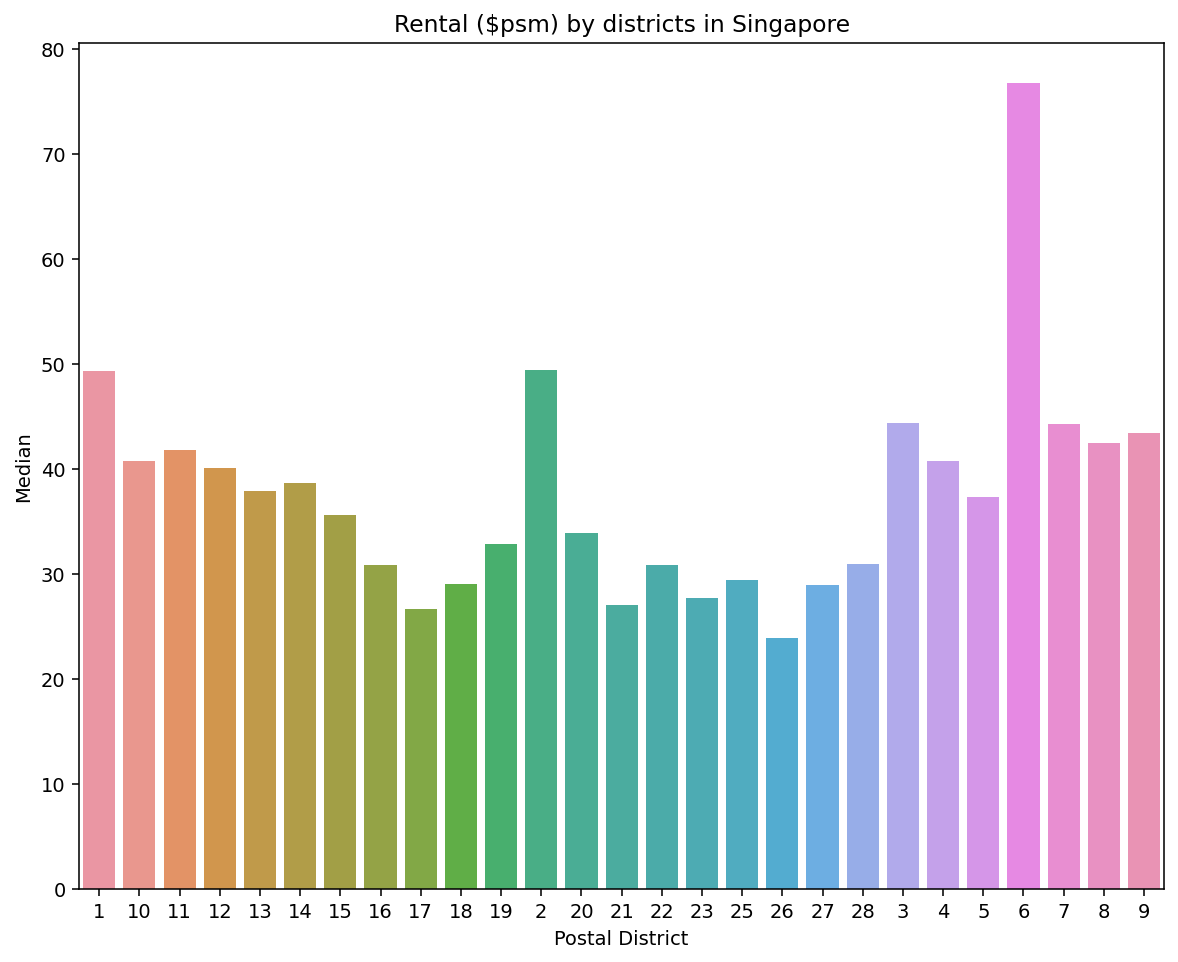

In [15]:
plt.figure(figsize=(10, 8), dpi=140)
plt.title('Rental ($psm) by districts in Singapore')
ax = sns.barplot(x='Postal District', y='Median', data=rental_district)
ax.set_xlabel('Postal District')
plt.show()

In [16]:
count_district = merged_rental.groupby('Postal District', as_index=False).count()

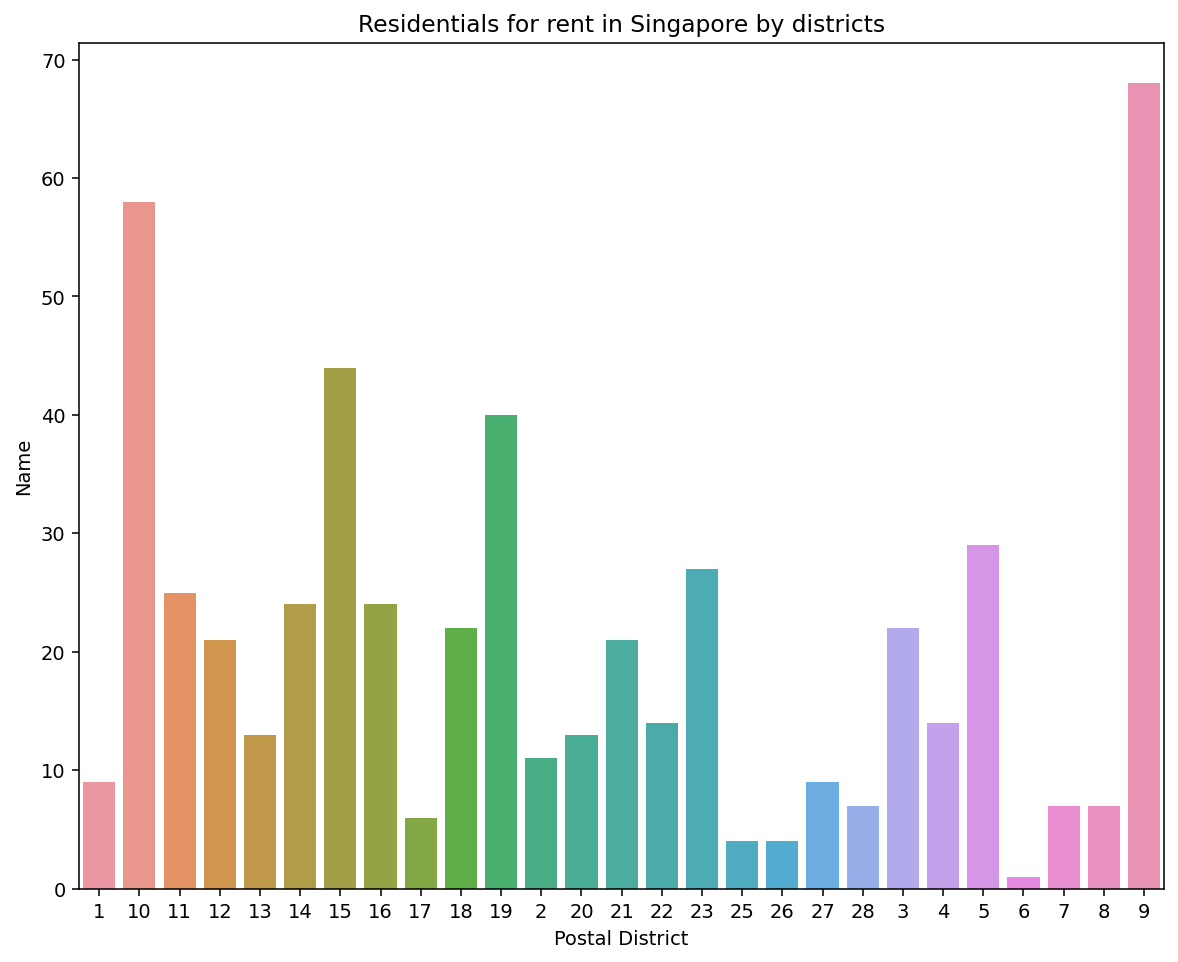

In [17]:
plt.figure(figsize=(10, 8), dpi=140)
plt.title('Residentials for rent in Singapore by districts')
ax = sns.barplot(x='Postal District', y='Name', data=count_district)
ax.set_xlabel('Postal District')
plt.show()

In [24]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
sg_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
district = plugins.MarkerCluster().add_to(sg_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(merged_rental['Latitude'], merged_rental['Longitude'], merged_rental['Postal District']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(district)

# display map
sg_map

Define Foursquare Credentials and Version.

In [19]:
CLIENT_ID = 'My ID'
CLIENT_SECRET = 'My Secret'
VERSION = '20180604'
LIMIT = 30

Define function to search nearby venues using Foursquare API

In [34]:
def getNearbyVenues(names, districts, medians, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, pos, median, lat, lng in zip(names, districts, medians, latitudes, longitudes):
  
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}'   
    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            pos,
            median,
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                             'Postal District',
                             'Median',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Define function to get most common venues.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##Explore the neighbourhoods located at areas with most expensive rents

In [30]:
ccr_list = ['1', '2', '6']
ccr_df = merged_rental[merged_rental['Postal District'].isin(ccr_list)]
ccr_df


,Name,Postal District,Median,Latitude,Longitude
6,76 SHENTON,2,54.55,1.273405,103.845581
14,ALTEZ,2,66.07,1.274690,103.844366
109,EMERALD GARDEN,1,38.54,1.301385,103.838993
111,EON SHENTON,2,58.00,1.273854,103.846222
142,HIGH STREET CENTRE,6,76.74,1.289973,103.849251
157,ICON,2,52.34,1.294668,103.850074
159,INTERNATIONAL PLAZA,2,34.43,1.275755,103.845900
197,LUMIERE,2,48.91,1.274218,103.846006
200,MARINA BAY RESIDENCES,1,57.14,1.279695,103.855207
201,MARINA BAY SUITES,1,43.37,1.280294,103.852246


In [35]:
ccr_venues = getNearbyVenues(names=ccr_df['Name'],
                             districts=ccr_df['Postal District'],
                             medians=ccr_df['Median'],
                                 latitudes=ccr_df['Latitude'],
                                 longitudes=ccr_df['Longitude']
                                )

In [38]:
# one hot encoding
ccr_onehot = pd.get_dummies(ccr_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ccr_onehot['Name'] = ccr_venues['Name'] 

# move neighborhood column to the first column
fixed_columns = [ccr_onehot.columns[-1]] + list(ccr_onehot.columns[:-1])
ccr_onehot = ccr_onehot[fixed_columns]

ccr_onehot.head()

,Name,American Restaurant,Art Gallery,Arts & Crafts Store,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Boutique,Brewery,Bubble Tea Shop,Buddhist Temple,Buffet,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Event Space,Food Court,French Restaurant,Gastropub,Gym,Gym / Fitness Center,...,Modern European Restaurant,Mosque,Museum,Music Store,Nail Salon,Noodle House,North Indian Restaurant,Other Great Outdoors,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Plaza,Pool,Ramen Restaurant,Restaurant,River,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Soup Place,Spa,Spanish Restaurant,Speakeasy,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Yoga Studio
0,76 SHENTON,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,76 SHENTON,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,76 SHENTON,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,76 SHENTON,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,76 SHENTON,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Name'] = ccr_grouped['Name']

for ind in np.arange(ccr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ccr_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,76 SHENTON,Japanese Restaurant,Coffee Shop,Bakery,Salad Place,Gym / Fitness Center,Restaurant,Spanish Restaurant,Mosque,Cocktail Bar,Ramen Restaurant
1,ALTEZ,Japanese Restaurant,Coffee Shop,Bakery,Dessert Shop,Salad Place,Spanish Restaurant,Gym / Fitness Center,Kebab Restaurant,Noodle House,Cocktail Bar
2,EMERALD GARDEN,Japanese Restaurant,Tea Room,Bakery,Bar,Clothing Store,Yoga Studio,Thai Restaurant,Pool,Bistro,Boutique
3,EON SHENTON,Japanese Restaurant,Coffee Shop,Bakery,Salad Place,Restaurant,Spanish Restaurant,Gym / Fitness Center,Kebab Restaurant,Mosque,Dessert Shop
4,HIGH STREET CENTRE,Yoga Studio,Cocktail Bar,French Restaurant,Hotel,Park,Music Store,Massage Studio,Lighthouse,Italian Restaurant,Indian Restaurant


Explore the neighbourhoods located at areas with least expensive rents

In [53]:
ocr_list = ['17', '21', '26']
ocr_df = merged_rental[merged_rental['Postal District'].isin(ocr_list)]
ocr_df

,Name,Postal District,Median,Latitude,Longitude
40,BUKIT REGENCY,21,21.57,1.346493,103.771087
41,BULLION PARK,26,24.35,1.391567,103.836180
57,CASTLE GREEN,26,25.57,1.386008,103.841085
60,CAVENDISH PARK,21,30.23,1.316635,103.775792
75,CLEMENTI PARK,21,21.25,1.329511,103.765995
112,ESTELLA GARDENS,17,22.99,1.360452,103.966904
149,HILLVIEW GREEN,21,23.08,1.357764,103.764214
154,HUME PARK I,21,20.00,1.353881,103.768246
155,HUME PARK II,21,22.61,1.355158,103.767471
195,LOYANG VALLEY,17,18.84,1.368246,103.970404


In [54]:
ocr_venues = getNearbyVenues(names=ocr_df['Name'],
                             districts=ocr_df['Postal District'],
                             medians=ocr_df['Median'],
                                 latitudes=ocr_df['Latitude'],
                                 longitudes=ocr_df['Longitude']
                                )

In [55]:
# one hot encoding
ocr_onehot = pd.get_dummies(ocr_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ocr_onehot['Name'] = ocr_venues['Name'] 

# move neighborhood column to the first column
fixed_columns = [ocr_onehot.columns[-1]] + list(ocr_onehot.columns[:-1])
ocr_onehot = ocr_onehot[fixed_columns]

ocr_onehot.head()

,Name,American Restaurant,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Bar,Bike Trail,Bistro,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Dance Studio,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Food Court,French Restaurant,Fried Chicken Joint,Garden,Gas Station,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Health Food Store,Historic Site,History Museum,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Malay Restaurant,Massage Studio,Metro Station,Movie Theater,Nature Preserve,Noodle House,Office,Park,Pet Store,Pizza Place,Playground,Plaza,Pool,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Supermarket,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Store
0,BUKIT REGENCY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BUKIT REGENCY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,BUKIT REGENCY,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,BUKIT REGENCY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,BUKIT REGENCY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
ocr_grouped = ocr_onehot.groupby('Name').mean().reset_index()
ocr_grouped

,Name,American Restaurant,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Bar,Bike Trail,Bistro,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Dance Studio,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Food Court,French Restaurant,Fried Chicken Joint,Garden,Gas Station,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Health Food Store,Historic Site,History Museum,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Malay Restaurant,Massage Studio,Metro Station,Movie Theater,Nature Preserve,Noodle House,Office,Park,Pet Store,Pizza Place,Playground,Plaza,Pool,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Supermarket,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Store
0,BUKIT REGENCY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,BULLION PARK,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.133333,0.000000,0.0000,0.000000,0.066667,0.066667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.133333,0.000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,CASTLE GREEN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,CAVENDISH PARK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.0000,0.000000,0.000000,0.222222,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.111111,0.000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
4,CLEMENTI PARK,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.0000,0.000000,0.125000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ocr_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ocr_neighborhoods_venues_sorted['Name'] = ocr_grouped['Name']

for ind in np.arange(ocr_grouped.shape[0]):
    ocr_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ocr_grouped.iloc[ind, :], num_top_venues)

ocr_neighborhoods_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BUKIT REGENCY,Convenience Store,Gym,Gas Station,Bus Stop,Electronics Store,Fast Food Restaurant,Dance Studio,Department Store,Dessert Shop,Diner
1,BULLION PARK,Bus Stop,Playground,Basketball Court,Gym,Bus Station,BBQ Joint,Garden,Pool,Bus Line,Department Store
2,CASTLE GREEN,Gym,Office,Basketball Court,Fast Food Restaurant,Dance Studio,Department Store,Dessert Shop,Diner,Electronics Store,Food Court
3,CAVENDISH PARK,Bus Station,Café,Thai Restaurant,Gym,Playground,Basketball Court,Pool,Restaurant,Video Store,Dessert Shop
4,CLEMENTI PARK,Bus Line,Asian Restaurant,Gym / Fitness Center,Bar,Playground,Plaza,Cafeteria,Bus Stop,Video Store,Dessert Shop
